https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

In [1]:
import math
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


import transformers
from datasets import load_dataset

# Transformer Model

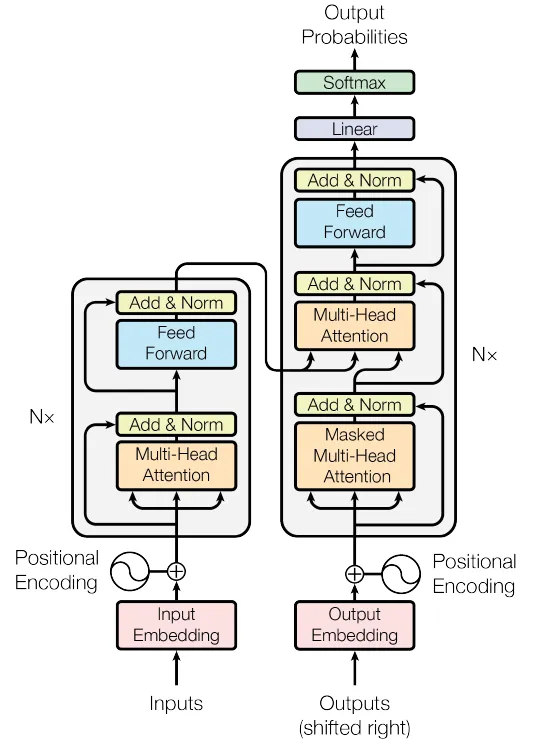

## Build Components

Position-wise FFN, MHA, Positional Encoding

### Multi Headed Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, debug_str = None):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.debug_str = debug_str
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if (self.debug_str == 'cross'):
            print('attn_scores:',attn_scores.shape, mask.shape)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Position-Wise FFN

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Encoder Layer

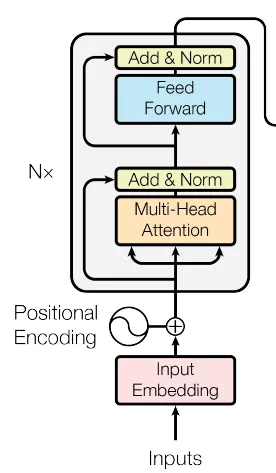

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## Decoder Layer

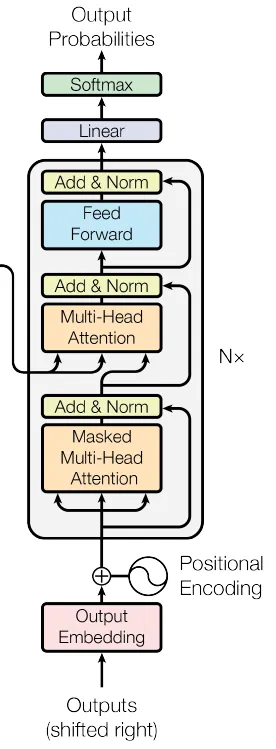

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)#, debug_str="cross")
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


## Transformer

Merging it all together

In [ ]:

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, pad_token_src = 0, pad_token_tgt = 0, device = 'cpu'):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.pad_token_src = pad_token_src
        self.pad_token_tgt = pad_token_tgt
        self.device = device
        self = self.to(self.device)

    def generate_mask(self, src_mask, tgt_mask):
        src_mask = src_mask.unsqueeze(1).unsqueeze(2)
        tgt_mask = tgt_mask.unsqueeze(1).unsqueeze(3)
        seq_length = tgt_mask.size(2)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask.to(self.device)
        return src_mask, tgt_mask

    def decode(self, src, bos_token_id, eos_token_id, mask=None, max_dec_length = 25):
        """
        for inference
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """

        tgt = torch.tensor([[bos_token_id]]*src.shape[0]).to(self.device)
        if mask:
            src_mask, tgt_mask = self.generate_mask(mask['src_mask'], mask['tgt_mask'])
        else:
            src_mask, tgt_mask = self.generate_mask(src!=self.pad_token_src, tgt!=self.pad_token_tgt)
        
        enc_output = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        out_labels = tgt
        unfinished_seq = np.array([1]*src.shape[0])
        i=0;
        while (sum(unfinished_seq)>0 & i<max_dec_length):
            dec_output = self.dropout(self.positional_encoding(self.decoder_embedding(out_labels)))
            for dec_layer in self.decoder_layers:
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
            output = self.fc(dec_output)

            out_labels = torch.cat((out_labels, output[:,-1:,:].argmax(-1)),dim=1)
            
            unfinished_seq[(out_labels[:,-1] == eos_token_id).cpu().numpy()] = 0

            i += 1;
        return out_labels
    
    def forward(self, src, tgt, mask = None):
        if mask:
            src_mask, tgt_mask = self.generate_mask(mask['src_mask'], mask['tgt_mask'])
        else:
            src_mask, tgt_mask = self.generate_mask(src!=self.pad_token_src, tgt!=self.pad_token_tgt)
                
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Data

In [2]:
dataset = load_dataset("cfilt/iitb-english-hindi")
print("train:%d, val:%d, test:%d"%(len(dataset['train']), len(dataset['validation']), len(dataset['test'])))

Found cached dataset parquet (/home/administrator/.cache/huggingface/datasets/cfilt___parquet/cfilt--iitb-english-hindi-e9387d78518bc7f8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

train:1659083, val:520, test:2507


## Load Tokenizers from saved

In [3]:
import transformers
from transformers import AutoTokenizer

hi_tokenizer = AutoTokenizer.from_pretrained("../translation/hindi-tokenizer")
en_tokenizer = AutoTokenizer.from_pretrained("../translation/eng-tokenizer")

In [4]:
hi_tokenizer.add_special_tokens({'pad_token': '[PAD]', 'cls_token': '<cls>', 'eos_token':'<eos>', 'bos_token' : '<s>'})

en_tokenizer.add_special_tokens({'pad_token': '[PAD]', 'cls_token': '<cls>', 'eos_token':'<eos>', 'bos_token' : '<s>'})

3

In [5]:
from tokenizers.processors import TemplateProcessing
en_tokenizer._tokenizer.post_processor = TemplateProcessing(
    single=en_tokenizer.bos_token + " $A " + en_tokenizer.eos_token,
    special_tokens=[(en_tokenizer.eos_token, en_tokenizer.eos_token_id), (en_tokenizer.bos_token, en_tokenizer.bos_token_id)],
)

In [ ]:
# en_sen = dataset['train']['translation'][1]['en']

# en_tokenizer.encode(en_sen, add_special_tokens = True)

## Data Exploration

In [24]:
# hi_length = -torch.ones(len(dataset['train']))
# en_length = -torch.ones(len(dataset['train']))
# for i, b in enumerate(tqdm(dataset['train'])):
#     hi_length[i] = hi_tokenizer(b['translation']['hi'], padding=True, truncation=True, return_tensors="pt")['input_ids'].shape[1]
#     en_length[i] = en_tokenizer(b['translation']['en'], padding=True, truncation=True, return_tensors="pt")['input_ids'].shape[1]

  0%|          | 0/1659083 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
# df = pd.DataFrame({'hi':hi_length, 'en':en_length})
# df = df.astype(int)
# df['hi_en'] = df.hi + df.en
# df = df.sort_values('hi_en', axis=0, ascending=False)
# df['index'] = df.index
# df.to_csv('train_token_size.csv',index=False)
# df


,hi,en,hi_en,index
1445892,1024,1024,2048,1445892
1290557,1024,1024,2048,1290557
1491388,1024,1024,2048,1491388
1476022,1024,833,1857,1476022
1561836,800,913,1713,1561836
...,...,...,...,...
1055963,0,2,2,1055963
1073719,0,2,2,1073719
1086756,0,2,2,1086756
1066364,0,2,2,1066364


In [ ]:
df = pd.read_csv("train_token_size.csv")

In [ ]:
bins = [0,10,100,200,300,400,500,1000,2000]
plt.hist(df['hi_en'][df['hi_en']>100], bins = bins)
plt.xticks(bins,rotation=85, ha='right')
plt.xticks(bins)

## Create Dataloader

In [ ]:
# subset = list(range(0, 16))
# dataset['train'] = torch.utils.data.Subset(dataset['train'], subset)
# dataset['validation'] = torch.utils.data.Subset(dataset['validation'], subset)

In [ ]:
BS = 2
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset['validation'], batch_size=BS, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=BS, shuffle=True)

# Train

## Instantiate Model

In [ ]:
src_vocab_size = len(hi_tokenizer)
tgt_vocab_size = len(en_tokenizer)
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 1024
dropout = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, 
                          d_ff, max_seq_length, dropout, pad_token_src = hi_tokenizer.pad_token_id, 
                          pad_token_tgt = en_tokenizer.pad_token_id, device = device)


## Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=en_tokenizer.pad_token_id)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train();

In [ ]:
loss_history = []
for epoch in range(100):
    epoch_loss = 0
    pbar = tqdm(train_loader)
    for batch, b in enumerate(pbar):
        if (batch+1%40000)==0:
            PATH = f"./transformer_epoch_{epoch}_batch_{batch}.pth"
            torch.save(transformer.state_dict(), PATH)

        hi_token = hi_tokenizer(b['translation']['hi'], padding=True, truncation=True, return_tensors="pt")
        en_token = en_tokenizer(b['translation']['en'], padding=True, truncation=True, return_tensors="pt")
        
        hi_input = hi_token['input_ids'].to(device)
        hi_masks = hi_token['attention_mask'].to(device)
        
        en_output = en_token['input_ids'].to(device)
        en_masks = en_token['attention_mask'].to(device)
        
        optimizer.zero_grad()
        output = transformer(hi_input, en_output[:, :-1], mask = {'src_mask':hi_masks, 'tgt_mask':en_masks[:, :-1]})
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), en_output[:, 1:].contiguous().view(-1).to(device))
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_description(f"Epoch: {epoch}, Loss: {epoch_loss/(batch+1)/BS:.5f} ")
        
    loss_history.append(epoch_loss/len(train_loader)/BS)
    

In [ ]:
%matplotlib inline
plt.plot(loss_history)

## Save & Load Model

In [ ]:
PATH = "./transformer_overfit.pth"
# PATH = f"./transformer_epoch_{epoch}_batch_{batch}.pth"

In [ ]:
torch.save(transformer.state_dict(), PATH)

In [ ]:
transformer.load_state_dict(torch.load(PATH))

# Evaluate

In [ ]:
transformer.eval()
for b in train_loader:
    break;

In [ ]:
hi_token = hi_tokenizer(b['translation']['hi'], padding=True, truncation=True, return_tensors="pt")
en_token = en_tokenizer(b['translation']['en'], padding=True, truncation=True, return_tensors="pt")

hi_input = hi_token['input_ids'].to(device)
hi_masks = hi_token['attention_mask'].to(device)

en_output = en_token['input_ids'].to(device)
en_masks = en_token['attention_mask'].to(device)

dec_out = transformer.decode(hi_input, en_tokenizer.bos_token_id, en_tokenizer.eos_token_id, max_dec_length = max_seq_length)

In [ ]:
print("\nhindi:",*list(map(hi_tokenizer.decode, hi_input)), sep='\n')
print("\ntarget:",*list(map(en_tokenizer.decode, en_output)), sep='\n')
print("\nmodel:",*list(map(en_tokenizer.decode, dec_out)), sep='\n')


# Debug

In [ ]:
%config Completer.use_jedi = True

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
transformer.eval();
for b in train_loader:
    break;

In [ ]:
hi_token = hi_tokenizer(b['translation']['hi'], padding=True, truncation=True, return_tensors="pt")
en_token = en_tokenizer(b['translation']['en'], padding=True, truncation=True, return_tensors="pt")

hi_input = hi_token['input_ids'].to(device)
hi_masks = hi_token['attention_mask'].to(device)

en_output = en_token['input_ids'].to(device)
en_masks = en_token['attention_mask'].to(device)

In [ ]:
b

In [ ]:
src = hi_input

In [ ]:
# output = transformer(src, tgt, mask = {'src_mask':hi_masks, 'tgt_mask':en_masks})

In [ ]:
src_mask, _ = transformer.generate_mask(hi_masks, en_masks)

src_embedded = transformer.dropout(transformer.positional_encoding(transformer.encoder_embedding(src)))

enc_output = src_embedded
for enc_layer in transformer.encoder_layers:
    enc_output = enc_layer(enc_output, src_mask)

## Length 2

In [ ]:
tgt = en_output[:, :2]
en_masks = en_masks[:, :tgt.shape[1]]
_, tgt_mask = transformer.generate_mask(hi_masks, en_masks)

In [ ]:
tgt_embedded = transformer.dropout(transformer.positional_encoding(transformer.decoder_embedding(tgt)))
dec_output = tgt_embedded
for dec_layer in transformer.decoder_layers[:1]:
    # dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
    attn_output = dec_layer.self_attn(dec_output, dec_output, dec_output, tgt_mask)
    dec_output = dec_layer.norm1(dec_output + dec_layer.dropout(attn_output))

    cross_attn_output = dec_layer.cross_attn(dec_output, enc_output, enc_output, src_mask)
    dec_output_cross = dec_layer.norm2(dec_output + dec_layer.dropout(cross_attn_output))

    ff_output = dec_layer.feed_forward(dec_output_cross)
    dec_output_final = dec_layer.norm3(dec_output_cross + dec_layer.dropout(ff_output))
    
    dec_output = dec_output_final
output_debug = transformer.fc(dec_output_final)

## Length 1

In [ ]:
enc_output_1 = enc_output
src_mask_1 = src_mask

In [ ]:
tgt_1 = en_output[:, :1]

en_masks = en_masks[:, :tgt_1.shape[1]]
_, tgt_mask_1 = transformer.generate_mask(hi_masks, en_masks)

In [ ]:
tgt_embedded_1 = transformer.dropout(transformer.positional_encoding(transformer.decoder_embedding(tgt_1)))
dec_output_1 = tgt_embedded_1
for dec_layer in transformer.decoder_layers[:1]:
    # dec_output_1 = dec_layer(dec_output_1, enc_output_1, src_mask_1, tgt_mask_1)
    attn_output_1 = dec_layer.self_attn(dec_output_1, dec_output_1, dec_output_1, tgt_mask_1)
    dec_output_1 = dec_layer.norm1(dec_output_1 + dec_layer.dropout(attn_output_1))

    cross_attn_output_1 = dec_layer.cross_attn(dec_output_1, enc_output_1, enc_output_1, src_mask_1)
    dec_output_cross_1 = dec_layer.norm2(dec_output_1 + dec_layer.dropout(cross_attn_output_1))

    ff_output_1 = dec_layer.feed_forward(dec_output_cross_1)
    dec_output_final_1 = dec_layer.norm3(dec_output_cross_1 + dec_layer.dropout(ff_output_1))

    dec_output_1 = dec_output_final_1
output_debug_1 = transformer.fc(dec_output_1)

## Comparison of Decoder Self Attention for diff length

In [ ]:
tgt_embedded = transformer.dropout(transformer.positional_encoding(transformer.decoder_embedding(en_output[:, :2])))
_, tgt_mask = transformer.generate_mask(hi_masks, en_masks[:, :2])
dec_output = transformer.decoder_layers[0].self_attn(tgt_embedded, tgt_embedded, tgt_embedded, tgt_mask)

In [ ]:
tgt_embedded_1 = transformer.dropout(transformer.positional_encoding(transformer.decoder_embedding(en_output[:, :1])))
_, tgt_mask_1 = transformer.generate_mask(hi_masks, en_masks[:, :1])
dec_output_1 = transformer.decoder_layers[0].self_attn(tgt_embedded_1, tgt_embedded_1, tgt_embedded_1, tgt_mask_1)

In [ ]:
en_masks[:,:2].shape
tgt_mask.shape

In [ ]:
tgt_mask = en_masks[:,:2].unsqueeze(1).unsqueeze(3)
tgt_mask.shape

In [ ]:
seq_length = tgt_mask.size(2)
nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
# nopeak_mask.shape
tgt_mask = tgt_mask & nopeak_mask.to(device)
tgt_mask.shape

In [ ]:
Q = transformer.decoder_layers[0].self_attn.W_q(tgt_embedded)
Q_1 = transformer.decoder_layers[0].self_attn.W_q(tgt_embedded_1)

K = transformer.decoder_layers[0].self_attn.W_k(tgt_embedded)
K_1 = transformer.decoder_layers[0].self_attn.W_k(tgt_embedded_1)

V = transformer.decoder_layers[0].self_attn.W_v(tgt_embedded)
V_1 = transformer.decoder_layers[0].self_attn.W_v(tgt_embedded_1)

In [ ]:
tgt_mask

In [ ]:
attn_scores = torch.matmul(Q, K.transpose(-2, -1))
attn_scores.masked_fill(tgt_mask == 0, -1e9)

In [ ]:
V_1.shape
V.shape
torch.norm(V_1 - V[:,:1,:])

In [ ]:
tgt_embedded_1.shape
tgt_embedded.shape
torch.norm(tgt_embedded_1 - tgt_embedded[:,:1,:])

dec_output.shape
dec_output_1.shape

torch.norm(dec_output_1 - dec_output[:,:1,:])

In [ ]:
lin_layer = transformer.decoder_layers[0].self_attn.W_q

In [ ]:
Q = lin_layer(tgt_embedded)

Q_1 = lin_layer(tgt_embedded_1)

In [ ]:
tgt_embedded_1.shape
tgt_embedded.shape
torch.norm(tgt_embedded_1 - tgt_embedded[:,:1,:])

Q_1.shape
Q.shape
torch.norm(Q_1 - Q[:,:1,:])

## Comparison

In [ ]:
dec_output.shape

In [ ]:
tgt_embedded.shape
dec_output.shape
tgt_mask.shape

tgt_embedded_1.shape
dec_output_1.shape
tgt_mask_1.shape

In [ ]:
torch.sum(dec_output_1 != dec_output[:,:1,:])

In [ ]:
torch.sum(src_embedded_1 != src_embedded_1)
tgt_embedded_1.shape
tgt_embedded.shape

In [ ]:
torch.sum(enc_output_1 != enc_output)


In [ ]:
tgt_embedded_1.shape
tgt_embedded.shape
torch.sum(tgt_embedded_1 != tgt_embedded[:,:1,:])

In [ ]:
dec_output_1.shape
dec_output.shape

In [ ]:
torch.sum(dec_output_1 != dec_output[:,:1,:])